## Intraday Option Chain Anomaly Detection

In [1]:
import time, os, json, logging, sys
print("First import completed.")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother
plt.style.use('ggplot')

print("Second import completed.")

# Set config
# TEST_DIR = os.path.realpath(os.path.join(os.getcwd(), '..', 'test'))
DATA_DIR = 'D:\\Git Repository\\_local_data_\\option_data\\Json_files\\'
# DATA_CLEAN_DIR = 'd:\\jupyter\\wooji\\repository\\Utils'

pd.set_option('display.max_rows', 500)
plt.style.use('seaborn')

# sys.path.append(TEST_DIR)
sys.path.append(DATA_DIR)
# sys.path.append(DATA_CLEAN_DIR)
print('Config all set.')

from helpFunc import *
# from anomaly_detection_helper import train_test_split
# import pickle
# import seaborn as sns
print("Third import completed.")

First import completed.
Second import completed.
Config all set.
Third import completed.


In [2]:
# inputs
ticker = 'SPY'
date_list = [dt.date(2021, 9, 8)]
folder_path = DATA_DIR + ticker

In [3]:
dir_list = os.listdir(folder_path)
x = dir_list[0]
print(x)

SPY_08312021 06_25_00.txt


In [4]:
file_list = [x for x in dir_list if dt.datetime.strptime(x[len(ticker)+1:-4],'%m%d%Y %H_%M_%S').date() in date_list]  

In [5]:
# %%time
# df = day_chain(ticker,folder_path,date_list)
# call_raw_df = df[df['putCall']=='CALL']
# put_raw_df = df[df['putCall']=='PUT']

In [6]:
# %%time
# read data
# how to speed up this process? 
# idea 1: a faster json loader thru multiple files
# idea 2: a faster method / algorithm to read thru the embedded dictionary
# current speed: 40 seconds per day (82 files, 750MB)


tup = readChain(ticker, folder_path, date_list)

call_raw_df = tup[0]
call_raw_df.set_index('Date', inplace = True)
put_raw_df = tup[1]
put_raw_df.set_index('Date', inplace = True)

call_raw_df.head()

,strike,bid_c,ask_c,last_c,volume_c,open_interest_c,volatility_c,delta_c,gamma_c,theta_c,vega_c,rho_c,Expiry
Date,,,,,,,,,,,,,
2021-09-08 06:25:00,310.0,141.13,141.34,0.00,0,0,132.319,1.0,0.0,-0.013,0.0,0.014,2021-09-08
2021-09-08 06:25:00,315.0,136.13,136.34,0.00,0,0,126.896,1.0,0.0,-0.013,0.0,0.014,2021-09-08
2021-09-08 06:25:00,320.0,131.13,131.34,131.89,0,13,121.572,1.0,0.0,-0.013,0.0,0.015,2021-09-08
2021-09-08 06:25:00,325.0,126.13,126.34,0.00,0,0,116.323,1.0,0.0,-0.013,0.0,0.015,2021-09-08
2021-09-08 06:25:00,330.0,121.13,121.34,0.00,0,0,111.148,1.0,0.0,-0.013,0.0,0.015,2021-09-08


### Plot volume (both difference and cumulative)

#### Plot aggregate volume and put-call ratio over time

In [7]:
call_raw_df.iloc[:, :-1] = call_raw_df.iloc[:, :-1].astype('float64')
put_raw_df.iloc[:, :-1] = put_raw_df.iloc[:, :-1].astype('float64')

In [59]:
call_price = call_raw_df.loc[call_raw_df.strike == 450].groupby(level=0).mean().last_c
put_price = put_raw_df.loc[put_raw_df.strike == 450].groupby(level=0).mean().last_p

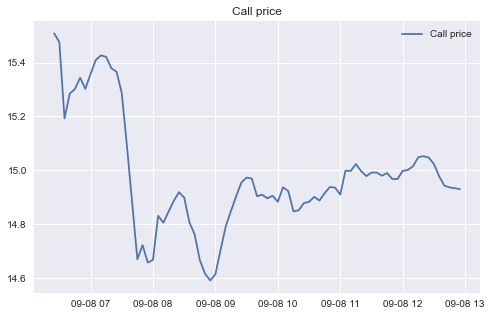

In [60]:
plt.figure(figsize=(8, 5))
plt.plot(call_price.index, call_price)
plt.legend(['Call price'])
plt.title('Call price')
plt.show()

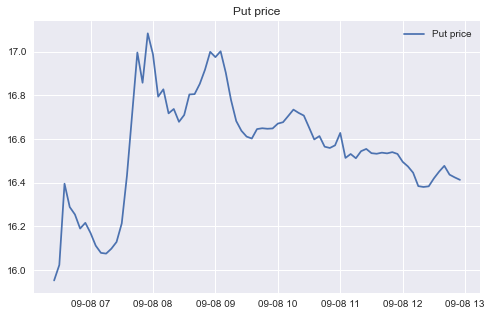

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(put_price.index, put_price)
plt.legend(['Put price'])
plt.title('Put price')
plt.show()

In [8]:
# cumulative volume
frequency = '10min'
volume_sum_call = call_raw_df.groupby(pd.Grouper(freq=frequency, dropna = True)).sum()['volume_c']
volume_sum_put = put_raw_df.groupby(pd.Grouper(freq=frequency, dropna = True)).sum()['volume_p']

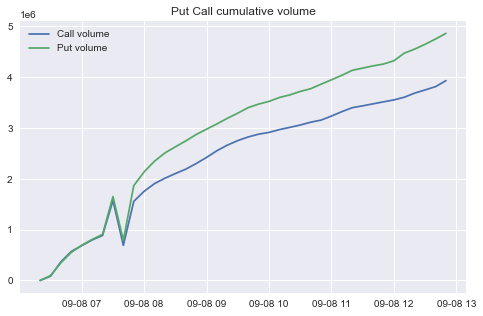

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(volume_sum_call.index, volume_sum_call, volume_sum_put.index, volume_sum_put)
plt.legend(['Call volume', 'Put volume'])
plt.title('Put Call cumulative volume')
plt.show()

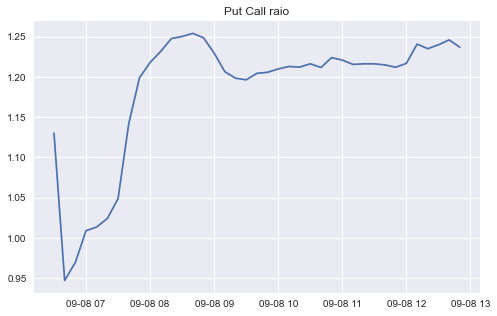

In [10]:
# put-call ratio
ratio = volume_sum_put / volume_sum_call
plt.figure(figsize=(8, 5))
plt.plot(ratio)
plt.title('Put Call raio')
plt.show()

#### Near the money volume, integer strike volume, far from the money volume surprises

In [11]:
# Near the money
frequency = '10min'
call_ntm = call_raw_df.loc[(call_raw_df['delta_c'] >= 0.40) & (call_raw_df['delta_c'] <= 0.60)]
volume_ntm_call = call_ntm.groupby(pd.Grouper(freq=frequency, dropna = True)).sum()['volume_c']
put_ntm = put_raw_df.loc[(put_raw_df['delta_p'] <= -0.40) & (put_raw_df['delta_p'] >= -0.60)]
volume_ntm_put = put_ntm.groupby(pd.Grouper(freq=frequency, dropna = True)).sum()['volume_p']

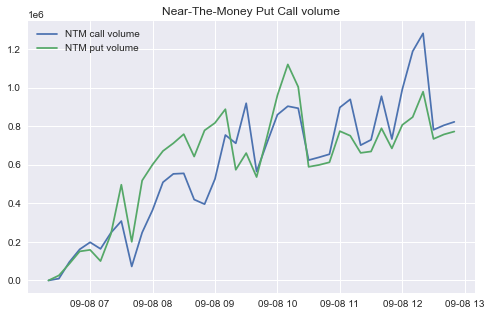

In [12]:
# ntm put call volume
plt.figure(figsize=(8, 5))
plt.plot(volume_ntm_call.index, volume_ntm_call, volume_ntm_put.index, volume_ntm_put)
plt.legend(['NTM call volume', 'NTM put volume'])
plt.title('Near-The-Money Put Call volume')
plt.show()

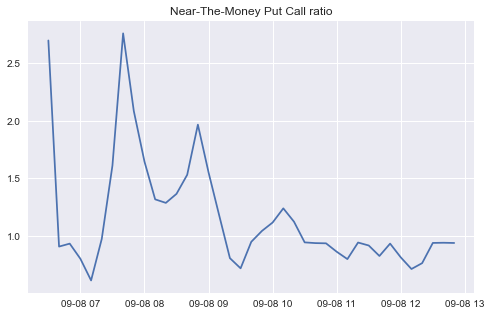

In [13]:
# ntm put-call ratio
ratio_ntm = volume_ntm_put / volume_ntm_call
plt.figure(figsize=(8, 5))
plt.plot(ratio_ntm)
plt.title('Near-The-Money Put Call ratio')
plt.show()

In [35]:
# Integer strike
# strike_list = np.arange(370, 385, 5)
strike_list = [440, 445, 450, 455, 460, 465]
call_int = call_raw_df.loc[call_raw_df['strike'].isin(strike_list)]
volume_int_call = call_int.groupby(pd.Grouper(freq=frequency, dropna = True)).sum()['volume_c']
put_int = put_raw_df.loc[put_raw_df['strike'].isin(strike_list)]
volume_int_put = put_int.groupby(pd.Grouper(freq=frequency, dropna = True)).sum()['volume_p']

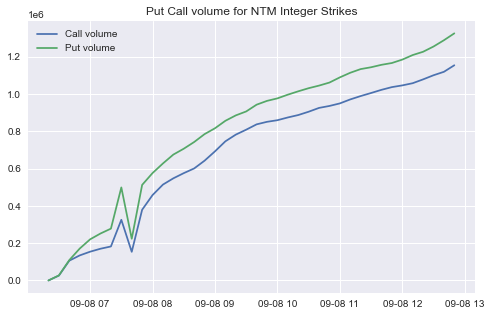

In [36]:
# Integer put call volume
plt.figure(figsize=(8, 5))
plt.plot(volume_int_call.index, volume_int_call, volume_int_put.index, volume_int_put)
plt.legend(['Call volume', 'Put volume'])
plt.title('Put Call volume for NTM Integer Strikes')
plt.show()

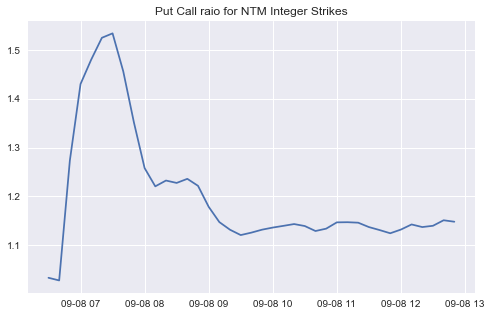

In [37]:
# Integer put-call ratio
ratio_int = volume_int_put / volume_int_call
plt.figure(figsize=(8, 5))
plt.plot(ratio_int)
plt.title('Put Call raio for NTM Integer Strikes')
plt.show()

In [17]:
# Far from the money put call ratio
call_fotm = call_raw_df.loc[(call_raw_df['delta_c'] <= 0.40) | (call_raw_df['delta_c'] >= 0.60)]
volume_fotm_call = call_fotm.groupby(pd.Grouper(freq=frequency, dropna = True)).sum()['volume_c']
put_fotm = put_raw_df.loc[(put_raw_df['delta_p'] >= -0.40) | (put_raw_df['delta_p'] <= -0.60)]
volume_fotm_put = put_fotm.groupby(pd.Grouper(freq=frequency, dropna = True)).sum()['volume_p']

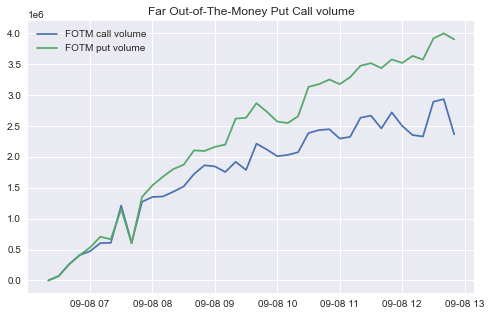

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(volume_fotm_call.index, volume_fotm_call, volume_fotm_put.index, volume_fotm_put)
plt.legend(['FOTM call volume', 'FOTM put volume'])
plt.title('Far Out-of-The-Money Put Call volume')
plt.show()

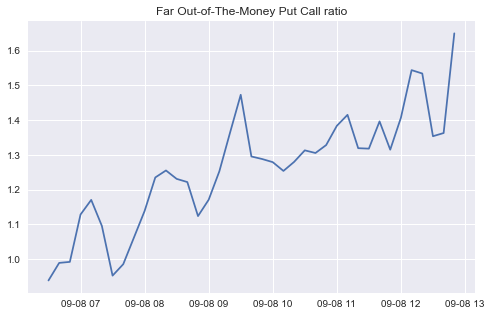

In [19]:
ratio_fotm = volume_fotm_put / volume_fotm_call
plt.figure(figsize=(8, 5))
plt.plot(ratio_fotm)
plt.title('Far Out-of-The-Money Put Call ratio')
plt.show()

### Plot price

### Volume surge monitor (original version)

In [20]:
call_raw_df.head()

,strike,bid_c,ask_c,last_c,volume_c,open_interest_c,volatility_c,delta_c,gamma_c,theta_c,vega_c,rho_c,Expiry
Date,,,,,,,,,,,,,
2021-09-08 06:25:00,310.0,141.13,141.34,0.00,0.0,0.0,132.319,1.0,0.0,-0.013,0.0,0.014,2021-09-08
2021-09-08 06:25:00,315.0,136.13,136.34,0.00,0.0,0.0,126.896,1.0,0.0,-0.013,0.0,0.014,2021-09-08
2021-09-08 06:25:00,320.0,131.13,131.34,131.89,0.0,13.0,121.572,1.0,0.0,-0.013,0.0,0.015,2021-09-08
2021-09-08 06:25:00,325.0,126.13,126.34,0.00,0.0,0.0,116.323,1.0,0.0,-0.013,0.0,0.015,2021-09-08
2021-09-08 06:25:00,330.0,121.13,121.34,0.00,0.0,0.0,111.148,1.0,0.0,-0.013,0.0,0.015,2021-09-08


In [22]:
call_df = call_raw_df.loc['2021-09-08']
put_df = put_raw_df.loc['2021-09-08']

In [23]:
call_exp_tup = rankExpiry(call_df, method = 'max')
call_expiry = call_exp_tup[0]
print('highest rank expiry date is: ' + call_expiry)
call_strike_tup = rankStrike(call_df, method = 'max')
call_strike = call_strike_tup[0]
print('highest rank strike is: ' + str(call_strike))

highest rank expiry date is: 2021-09-17
highest rank strike is: 450.0


In [24]:
# call_df.Expiry.tail(100)

In [25]:
call_strike = 455.0
put_strike = 440.0

In [26]:
put_df.groupby(pd.Grouper(freq='D')).sum()['volume_p'] / call_df.groupby(pd.Grouper(freq='D')).sum()['volume_c']

Date
2021-09-08    1.211021
Freq: D, dtype: float64

In [27]:
exp_date = '2021-09-17'

In [28]:
call_fil_df = call_df.loc[(call_df.Expiry == exp_date) & (call_df.strike == call_strike)]
put_fil_df = put_df.loc[(put_df.Expiry == exp_date) & (put_df.strike == put_strike)]

In [29]:
call_group_df = call_df.loc[(call_df.Expiry == exp_date)].groupby(level = 'Date').sum()
put_group_df = put_df.loc[(put_df.Expiry == exp_date)].groupby(level = 'Date').sum()

In [30]:
put_group_df['volume_p'][-1] / call_group_df['volume_c'][-1]

1.0521781487884316

In [31]:
pd.set_option('display.max_rows', None)
call_fil_df.volume_c.diff()

Date
2021-09-08 06:25:00       NaN
2021-09-08 06:30:00       2.0
2021-09-08 06:35:00     312.0
2021-09-08 06:40:00     174.0
2021-09-08 06:45:00     297.0
2021-09-08 06:50:00     271.0
2021-09-08 06:55:00      54.0
2021-09-08 07:00:00      79.0
2021-09-08 07:05:00     182.0
2021-09-08 07:10:00     108.0
2021-09-08 07:15:00      95.0
2021-09-08 07:20:00     134.0
2021-09-08 07:25:00     733.0
2021-09-08 07:30:00     124.0
2021-09-08 07:35:00     322.0
2021-09-08 07:35:00       0.0
2021-09-08 07:45:00    2132.0
2021-09-08 07:50:00     888.0
2021-09-08 07:55:00     440.0
2021-09-08 08:00:00     307.0
2021-09-08 08:05:00     102.0
2021-09-08 08:10:00     119.0
2021-09-08 08:15:00      80.0
2021-09-08 08:20:00      51.0
2021-09-08 08:25:00      21.0
2021-09-08 08:30:00      39.0
2021-09-08 08:35:00      59.0
2021-09-08 08:40:00     119.0
2021-09-08 08:45:00    2059.0
2021-09-08 08:50:00     600.0
2021-09-08 08:55:00     272.0
2021-09-08 09:00:00     169.0
2021-09-08 09:05:00      73.0
2021-

In [32]:
pd.set_option('display.max_rows', None)
put_fil_df.volume_p.diff()

Date
2021-09-08 06:25:00       NaN
2021-09-08 06:30:00       2.0
2021-09-08 06:35:00    1510.0
2021-09-08 06:40:00    2080.0
2021-09-08 06:45:00      30.0
2021-09-08 06:50:00    3182.0
2021-09-08 06:55:00      46.0
2021-09-08 07:00:00    1032.0
2021-09-08 07:05:00     328.0
2021-09-08 07:10:00      80.0
2021-09-08 07:15:00      56.0
2021-09-08 07:20:00      47.0
2021-09-08 07:25:00       4.0
2021-09-08 07:30:00      78.0
2021-09-08 07:35:00     182.0
2021-09-08 07:35:00       0.0
2021-09-08 07:45:00     651.0
2021-09-08 07:50:00     178.0
2021-09-08 07:55:00    1360.0
2021-09-08 08:00:00     202.0
2021-09-08 08:05:00     299.0
2021-09-08 08:10:00      43.0
2021-09-08 08:15:00      98.0
2021-09-08 08:20:00     231.0
2021-09-08 08:25:00     111.0
2021-09-08 08:30:00     318.0
2021-09-08 08:35:00      78.0
2021-09-08 08:40:00     119.0
2021-09-08 08:45:00      26.0
2021-09-08 08:50:00     100.0
2021-09-08 08:55:00     183.0
2021-09-08 09:00:00    1043.0
2021-09-08 09:05:00     400.0
2021-

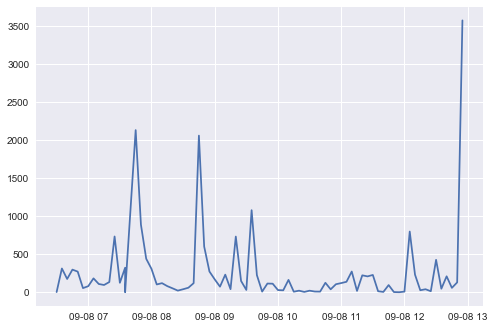

In [33]:
plt.plot(call_fil_df.volume_c.diff())

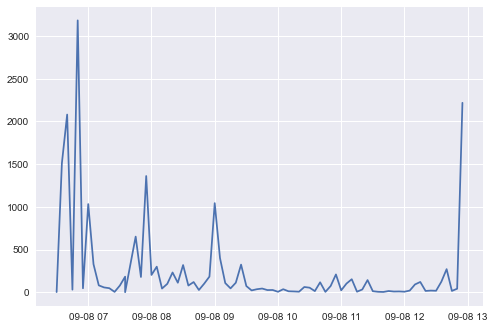

In [34]:
plt.plot(put_fil_df.volume_p.diff())